# **Malicious URLs Notebook**

## Step 1: Handle imports and import CSV file from shareable link

In [ ]:
!pip install -q tld # Top level domain
!pip install -U -q PyDrive
!pip install -q xgboost

     |████████████████████████████████| 412 kB 23.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

from sklearn.dummy import DummyClassifier # baseline model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler # data is normal distributed, hence using StandardScaler

from xgboost import XGBClassifier

from typing import Tuple, Union

from scipy.stats import kstest

from urllib.parse import urlparse
from tld import get_tld, is_tld

In [ ]:
# Authenticate user on google colab
auth.authenticate_user()

# Create google auth session and pass credentials
g_auth = GoogleAuth()
g_auth.credentials = GoogleCredentials.get_application_default()

# Allow colab session to access drive folders and files
drive = GoogleDrive(g_auth)

In [ ]:
# Now that colab is allowed to access drive, we can access sharable link
link = "https://drive.google.com/file/d/1n8D6UsEORc4xn6TE_HbeBzGD7V8p2NWT/view?usp=share_link"

# Regular expression to filter the url for the file id of the shareable link
file_id = re.search("[https]*:\/{2}[a-z]+.[a-z]+.[a-z]+\/file\/d\/(.*)\/", link).group(1)

# Temporarily store the csv file in the colab session
csv_file = drive.CreateFile({"id":file_id})
csv_file.GetContentFile("malicious_phish.csv") # now we don't need to manually import every time

# Read csv file to dataframe
df = pd.read_csv("malicious_phish.csv")
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


## Step 2: Gain understanding of the data

In [ ]:
# Initial information about the dataset, i.e. columns number, column name, count, and dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
# How many null values are present
df.isnull().sum()

url     0
type    0
dtype: int64

In [ ]:
# Store and display value counts
value_counts = df.type.value_counts()
value_counts

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [ ]:
# Map every category found in df["type"] to numerical categorical variable
numerical_categories = {}
for index, category in enumerate(value_counts.index):
    numerical_categories[f"{category}"] = index

# Create new feature with target variable corresponding to numerical_categories
df["target"] = [numerical_categories[category] for category in df["type"]]
df.head()

,url,type,target
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


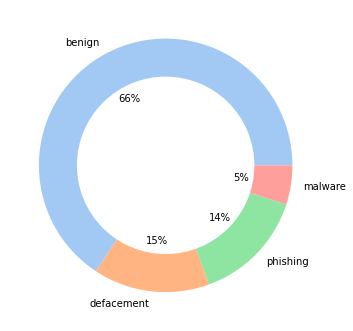

In [ ]:
# Nice little color palette, we can use throughout the paper
colors = sns.color_palette("pastel")[0:5]

# Donut chart for the target variable ratios
plt.figure(figsize=(5, 5))

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.pie(value_counts, labels=value_counts.index, colors=colors, autopct="%.0f%%")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'count')

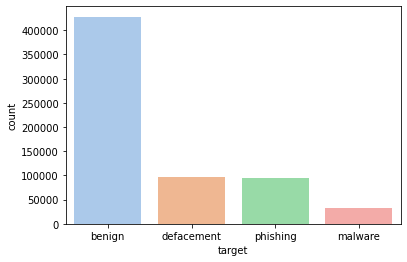

In [ ]:
# Supplied barplot visualisation
sns.barplot(x=value_counts.index, y=value_counts, palette=colors)
plt.xlabel("target")
plt.ylabel("count")

## Step 3: Data preprocessing and feature engineering

In [ ]:
# Function to map new feature based on whether ip address in url
# courtesy of https://www.kaggle.com/code/jingyanshang/url-s-feature-analysis/notebook
def url_is_ip_address(url: str) -> int:
    match = re.search(
            '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
            '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
            '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
            '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
            '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
            '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
            '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
            '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6

    if match:
        return 1
    else:
        return 0

# Function to map new feature based on http[s] protocol
def https_secured(url: str) -> int:
    try:
        protocol = re.search("^(http|https)://", url)

        if protocol == None:
            return 0
        elif protocol.group(1) == "https":
            return 1
        else:
            return 0
    except Exception as err:
        print(f"[Error]: {err}")
        return 0

def count_digits(url: str) -> int:
    digits = 0
    for x in url:
        if x.isnumeric():
            digits += 1
    return digits

def count_letters(url: str) -> int:
    letters = 0
    for x in url:
        if x.isalpha():
            letters += 1
    
    return letters

In [ ]:
def process_tld(url: str, fix_protos: bool = False) -> Tuple[str, str, str, str]:
    res = get_tld(url, as_object=True, fail_silently=False, fix_protocol=fix_protos)

    subdomain = res.subdomain
    domain = res.domain
    tld = res.tld
    fld = res.fld

    return subdomain, domain, tld, fld

def process_url_with_tld(row: pd.Series) -> Tuple[str, str, str, str]:
    try:
        if row["is_ip"] == 0:
            return process_tld(row["url"], fix_protos=True)

        else:
            subdomain = domain = tld = fld = None

            return subdomain, domain, tld, fld
    except Exception as err:
        return None, None, None, None

def contains_shortening_service(url: str) -> int:
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    
    if match:
        return 1
    else:
        return 0

# Function for returning length, even if text is None
def count_len(text: str) -> int:
    if text == None:
        return 0
    else:
        return len(text)

In [ ]:
start = time.time()
# For every url, check if ip address is embedded within
df["is_ip"] = df["url"].apply(lambda x: url_is_ip_address(x))

# For every url, check if http[s] is present and map to new feature
df["is_https_secured"] = df["url"].apply(lambda x: https_secured(x))

# Count numbers of characters inherent in url string
df["url_length"] = df["url"].apply(lambda x: len(x))

# Extract the primary domain from the url
df[['subdomain', 'domain', 'tld', 'fld']] = df.apply(lambda x: process_url_with_tld(x), axis=1, result_type="expand")

"""
All rows missing ['subdomain', 'domain', 'tld', 'fld'] (that is, because they
are invalid) will return 0, because they don't adhere to the standard
- most of them are likely to return 0 if the url is an ip address
"""
df["subdomain_len"] = df["subdomain"].apply(lambda x: count_len(x))
df["tld_len"] = df["tld"].apply(lambda x: count_len(x))
df["fld_len"] = df["fld"].apply(lambda x: count_len(x))

# Count the digits in the url
df["digit_count"] = df["url"].apply(lambda x: count_digits(x))

# Count the letters in the url
df["letter_count"] = df["url"].apply(lambda x: count_letters(x))

# Count selected special characters, excluding directory seperator single slash
special_characters = ['@','?','-','=','.','#','%','+','$','!','*',',','//']

for char in special_characters:
    df[char] = df["url"].apply(lambda x: x.count(char))

df["contains_shortening"] = df["url"].apply(lambda x: contains_shortening_service(x))

# Total count of special characters in the url
df["special_count"] = df[special_characters].sum(axis=1)

print(f"time elapsed: {(time.time() - start):.2f} seconds")

df.head()

time elapsed: 66.36 seconds


,url,type,target,is_ip,is_https_secured,url_length,subdomain,domain,tld,fld,...,#,%,+,$,!,*,",",//,contains_shortening,special_count
0,br-icloud.com.br,phishing,2,0,0,16,,br-icloud,com.br,br-icloud.com.br,...,0,0,0,0,0,0,0,0,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,0,35,,mp3raid,com,mp3raid.com,...,0,0,0,0,0,0,0,0,0,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,0,31,,bopsecrets,org,bopsecrets.org,...,0,0,0,0,0,0,0,0,0,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,0,0,88,www,garage-pirenne,be,garage-pirenne.be,...,0,0,0,0,0,0,0,1,0,10
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,0,0,235,,adventure-nicaragua,net,adventure-nicaragua.net,...,0,0,0,0,0,0,0,1,0,8


In [ ]:
df[['subdomain', 'domain', 'tld', 'fld']].isna().sum()[0] - df["is_ip"].value_counts()[1]

90

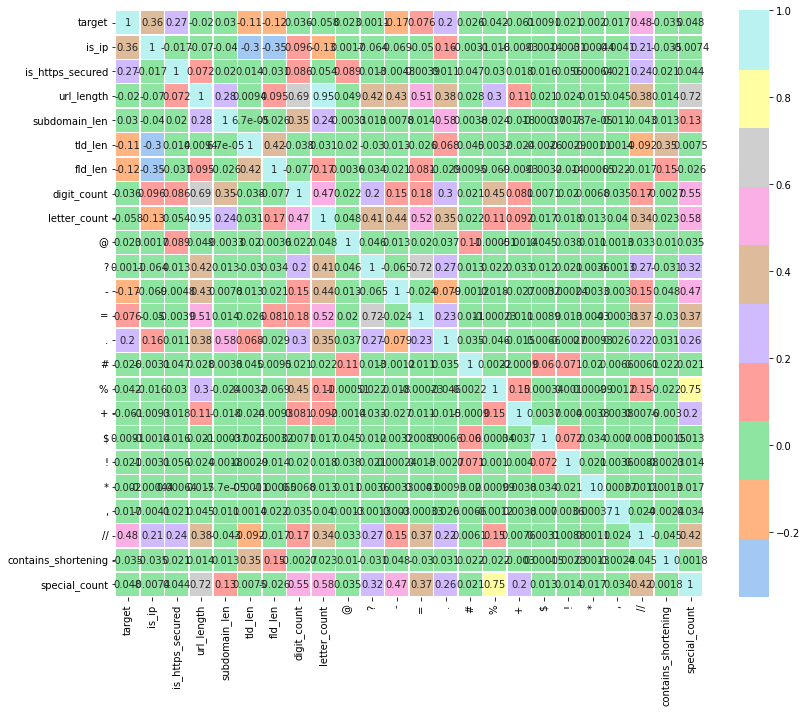

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), linewidths=.5, cmap=sns.color_palette("pastel"), annot=True)
plt.tight_layout()
plt.show()

In [ ]:
# checkpoint
df.to_csv("final_malicious_phish.csv", index=False)

# folder id of cybersecurity champions
folder_id = "1rX7uYeG-eonAp8ou1tsBw-Ccfkao1LJr"

# create empty file
file_ = drive.CreateFile({"parents": [{"kind": "drive#linkfilelink", "id": folder_id}]})

# populate empty file with new csv and upload
# https://github.com/googlearchive/PyDrive/blob/master/examples/using_folders.py
file_.SetContentFile("final_malicious_phish.csv")
file_.Upload()

## Step 4: Create X and y subsets; Create training and testing subsets

In [ ]:
# method for reducing memory size of dataframe (https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65/notebook)
def reduce_memory(df: pd.DataFrame) -> pd.DataFrame:
    current_memory_usage = df.memory_usage().sum() / 1024 ** 2 # convert bytes to MB
    print(f"Memory of dataframe: {current_memory_usage} MB\n")

    for col in df.columns:
        if df[col].dtype != object:

            print("**********************")
            print(f"Column: {col}")
            print("----------------------")
            print(f"Dtype (before): {df[col].dtype}")
            print(f"Memory (before): {df[col].memory_usage() / 1024 ** 2:.2f} MB")
            print("----------------------")

            is_int = False

            min, max = df[col].min(), df[col].max()
            
            to_int = df[col].fillna(0).astype(np.int64)
            res = (df[col] - to_int)
            res = res.sum()
            if res > -0.01 and res < 0.01:
                is_int = True

            if is_int:
                if min >= 0:
                    if max < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif max < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif max < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if min > np.iinfo(np.int8).min and max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif min > np.iinfo(np.int16).min and max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif min > np.iinfo(np.int32).min and max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif min > np.iinfo(np.int64).min and max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            else:
                df[col] = df[col].astype(np.float32)

            print(f"Dtype (after): {df[col].dtype}")
            print(f"memory (after): {df[col].memory_usage() / 1024 ** 2:.2f} MB")
            print("**********************\n")

    new_memory_usage = df.memory_usage().sum() / 1024 ** 2
    print(f"Memory usage of {current_memory_usage:.2f} MB reduced to {new_memory_usage:.2f} MB")
    print(f"% reduced: {100 - (100 * new_memory_usage/current_memory_usage):.2f}%")

    return df

In [ ]:
# Authenticate user on google colab
auth.authenticate_user()

# Create google auth session and pass credentials
g_auth = GoogleAuth()
g_auth.credentials = GoogleCredentials.get_application_default()

# Allow colab session to access drive folders and files
drive = GoogleDrive(g_auth)

file_link = "https://drive.google.com/file/d/1LFIA4qEWLMZNijxYTthkF3ppdaPblesI/view?usp=share_link"

file_id = re.search("[https]*:\/{2}[a-z]+.[a-z]+.[a-z]+\/file\/d\/(.*)\/", file_link).group(1)

csv_file = drive.CreateFile({"id":file_id})
csv_file.GetContentFile("final_malicious_phish.csv")

df = pd.read_csv("final_malicious_phish.csv")
df.head()

,url,type,target,is_ip,is_https_secured,url_length,subdomain,domain,tld,fld,...,#,%,+,$,!,*,",",//,contains_shortening,special_count
0,br-icloud.com.br,phishing,2,0,0,16,NaN,br-icloud,com.br,br-icloud.com.br,...,0,0,0,0,0,0,0,0,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,0,35,NaN,mp3raid,com,mp3raid.com,...,0,0,0,0,0,0,0,0,0,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,0,31,NaN,bopsecrets,org,bopsecrets.org,...,0,0,0,0,0,0,0,0,0,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,0,0,88,www,garage-pirenne,be,garage-pirenne.be,...,0,0,0,0,0,0,0,1,0,10
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,0,0,235,NaN,adventure-nicaragua,net,adventure-nicaragua.net,...,0,0,0,0,0,0,0,1,0,8


In [ ]:
# method to reduce dataframe by a fraction, while preserving target variable distribution
def shorten_dataframe(df: pd.DataFrame, column: str, fraction: float) -> pd.DataFrame:
    final_df = df.iloc[0:0]
    
    print(f"Target column: {column}\nShorten to {fraction * 100}%\n")

    for index in df[column].value_counts().index:
        final_df = pd.concat([final_df, df[df[column] == index].sample(frac=fraction, random_state=42)])
        print(f"{index} reduced from {len(df[df[column] == index])} to {len(final_df[final_df[column] == index])}")

    print(f"\n{final_df[column].value_counts()}")

    return final_df

In [ ]:
final_df = shorten_dataframe(df, column="target", fraction=0.02)

Target column: target
Shorten to 2.0%

0 reduced from 428103 to 8562
1 reduced from 96457 to 1929
2 reduced from 94111 to 1882
3 reduced from 32520 to 650

0    8562
1    1929
2    1882
3     650
Name: target, dtype: int64


In [ ]:
final_df["target"] = df["target"].replace([2, 3], 1)
final_df.url_length.value_counts()

31     413
33     286
34     247
27     242
40     238
      ... 
301      1
314      1
253      1
265      1
206      1
Name: url_length, Length: 287, dtype: int64

In [ ]:
reduce_memory(final_df)

Memory of dataframe: 3.0800857543945312 MB

**********************
Column: target
----------------------
Dtype (before): int64
Memory (before): 0.20 MB
----------------------
Dtype (after): uint8
memory (after): 0.11 MB
**********************

**********************
Column: is_ip
----------------------
Dtype (before): int64
Memory (before): 0.20 MB
----------------------
Dtype (after): uint8
memory (after): 0.11 MB
**********************

**********************
Column: is_https_secured
----------------------
Dtype (before): int64
Memory (before): 0.20 MB
----------------------
Dtype (after): uint8
memory (after): 0.11 MB
**********************

**********************
Column: url_length
----------------------
Dtype (before): int64
Memory (before): 0.20 MB
----------------------
Dtype (after): uint16
memory (after): 0.12 MB
**********************

**********************
Column: subdomain_len
----------------------
Dtype (before): int64
Memory (before): 0.20 MB
----------------------
Dtyp

,url,type,target,is_ip,is_https_secured,url_length,subdomain,domain,tld,fld,...,#,%,+,$,!,*,",",//,contains_shortening,special_count
514768,montreal.louer.com/ahuntsic-rentals/houses-rent/,benign,0,0,0,48,montreal,louer,com,louer.com,...,0,0,0,0,0,0,0,0,0,4
222536,comunidade.sol.pt/blogs/hytigin/default.aspx,benign,0,0,0,44,comunidade,sol,pt,sol.pt,...,0,0,0,0,0,0,0,0,0,3
276748,youtube.com/watch?v=PUDOlyCpHwo,benign,0,0,0,31,NaN,youtube,com,youtube.com,...,0,0,0,0,0,0,0,0,0,3
50193,uiowa.edu/~acadtech/phonetics/,benign,0,0,0,30,NaN,uiowa,edu,uiowa.edu,...,0,0,0,0,0,0,0,0,0,1
339822,flixster.com/actor/steve-mcqueen,benign,0,0,0,32,NaN,flixster,com,flixster.com,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130543,http://9779.info/%E6%96%87%E6%98%8E%E5%9C%A8%E...,malware,1,0,0,90,NaN,9779,info,9779.info,...,0,24,0,0,0,0,0,1,0,26
550575,https://mitsui-jyuku.mixh.jp/uploads/22013687e...,malware,1,0,1,76,mitsui-jyuku,mixh,jp,mixh.jp,...,0,0,0,0,0,0,0,1,0,5
550863,https://mitsui-jyuku.mixh.jp/uploads/148N8Mk0.exe,malware,1,0,1,49,mitsui-jyuku,mixh,jp,mixh.jp,...,0,0,0,0,0,0,0,1,0,5
540674,http://134.209.165.195/Pipe/i586,malware,1,1,0,32,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,4


In [ ]:
X = final_df.drop(["url", "type", "target", "subdomain", "domain", "tld", "fld"], axis=1)
y = final_df["target"]

In [ ]:
# Check data distribution for normality to determine how to scale the data
# kolmogorov-smirnov test
for column in X.columns:
    print(f"{column:20s}:\t{'Normal' if kstest(X[column], 'norm')[1]<0.05 else 'Not normal':10s}:\t{kstest(X[column], 'norm')}")

is_ip               :	Normal    :	KstestResult(statistic=0.5, pvalue=0.0)
is_https_secured    :	Normal    :	KstestResult(statistic=0.5, pvalue=0.0)
url_length          :	Normal    :	KstestResult(statistic=0.9999999990134123, pvalue=0.0)
subdomain_len       :	Normal    :	KstestResult(statistic=0.5, pvalue=0.0)
tld_len             :	Normal    :	KstestResult(statistic=0.9583602112907058, pvalue=0.0)
fld_len             :	Normal    :	KstestResult(statistic=0.9810786719970519, pvalue=0.0)
digit_count         :	Normal    :	KstestResult(statistic=0.5007083645580022, pvalue=0.0)
letter_count        :	Normal    :	KstestResult(statistic=0.9999683287581669, pvalue=0.0)
@                   :	Normal    :	KstestResult(statistic=0.5, pvalue=0.0)
?                   :	Normal    :	KstestResult(statistic=0.5, pvalue=0.0)
-                   :	Normal    :	KstestResult(statistic=0.5, pvalue=0.0)
=                   :	Normal    :	KstestResult(statistic=0.5, pvalue=0.0)
.                   :	Normal    :	Kst

In [ ]:
X.isna().sum()

is_ip                  0
is_https_secured       0
url_length             0
subdomain_len          0
tld_len                0
fld_len                0
digit_count            0
letter_count           0
@                      0
?                      0
-                      0
=                      0
.                      0
#                      0
%                      0
+                      0
$                      0
!                      0
*                      0
,                      0
//                     0
contains_shortening    0
special_count          0
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [ ]:
y_test.value_counts()

0    1713
1     892
Name: target, dtype: int64

## Step 5: Train machine learning models

### 5.1 Dummy classifier

In [ ]:
from tabulate import tabulate

def classification_report(y_test: pd.Series, y_pred: pd.Series):
    evaluation_methods = [f1_score, recall_score, precision_score]

    print("****************************************************")
    print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("----------------------------------------------------")

    micro, macro = ["micro"], ["macro"]
    for method in evaluation_methods:
        micro_result = f"{method(y_test, y_pred, average='micro', zero_division=0):.4f}"
        macro_result = f"{method(y_test, y_pred, average='macro', zero_division=0):.4f}"

        micro.append(micro_result)
        macro.append(macro_result)
    
    print(tabulate([micro, macro], headers=[method.__name__ for method in evaluation_methods]))
    print("----------------------------------------------------\n")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print("\n****************************************************")

In [ ]:
def classification_report(y_test: pd.Series, y_pred: pd.Series, y_pred_proba: pd.Series):
    evaluation_methods = [f1_score, recall_score, precision_score]

    print("\n****************************************************")
    print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"roc_auc_score: {roc_auc_score(y_test, y_pred):.4f}")
    print("----------------------------------------------------")

    for method in evaluation_methods:
        print(f"{method.__name__:20s}:{method(y_test, y_pred, zero_division=0):.4f}")
    
    print("----------------------------------------------------")
    print("ROC-Curve\n")
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
    plt.plot([0, 1], [0, 1], linestyle='--')

    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')

    # show the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("")
    plt.show()
    print("----------------------------------------------------")
    cm = confusion_matrix(y_test, y_pred)
    
    matrix = sns.heatmap(cm, annot=True, cmap=colors, fmt="g", linewidths=0.5, linecolor="black")
    matrix.set_title("Confusion matrix")
    
    matrix.set_xlabel("\nPredicted values")
    matrix.set_ylabel("Actual values")
    
    matrix.xaxis.set_ticklabels(["Benign", "Malicious"])
    matrix.yaxis.set_ticklabels(["Benign", "Malicious"])
    
    plt.show()
    print("\n****************************************************")


****************************************************
accuracy: 0.6576
roc_auc_score: 0.5000
----------------------------------------------------
f1_score            :0.0000
recall_score        :0.0000
precision_score     :0.0000
----------------------------------------------------
ROC-Curve



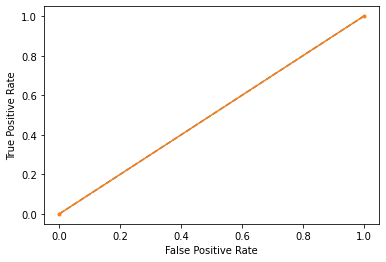

----------------------------------------------------


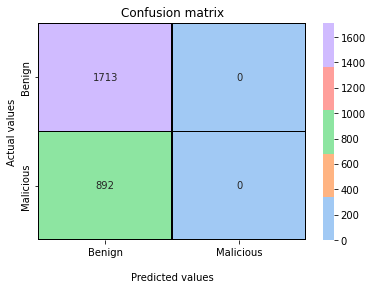


****************************************************


In [ ]:
dummy_classifier = DummyClassifier(strategy="most_frequent", random_state=42)

dummy_classifier.fit(X_train_std, y_train)

dummy_test_pred = dummy_classifier.predict(X_test_std)
dummy_pred_proba = dummy_classifier.predict_proba(X_test_std)

classification_report(y_test, dummy_test_pred, dummy_pred_proba)

###5.2 Random Forest



****************************************************
accuracy: 0.8791
roc_auc_score: 0.8310
----------------------------------------------------
f1_score            :0.7934
recall_score        :0.6783
precision_score     :0.9558
----------------------------------------------------
ROC-Curve



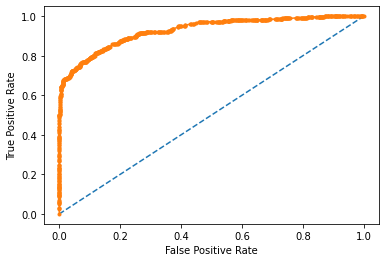

----------------------------------------------------


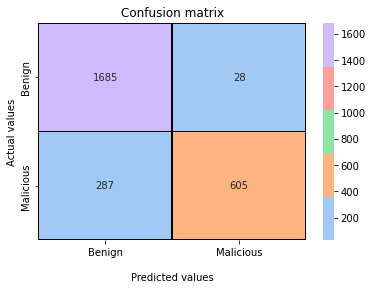


****************************************************


In [ ]:
random_forest = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [10, 50, 100],
    "max_features": ["log2", "sqrt"],
    "max_depth": [2, 3, 5],
    "max_leaf_nodes": [2, 4, 6]
}

rf_grid = GridSearchCV(random_forest, param_grid=param_grid, cv=10)

rf_grid.fit(X_train_std, y_train)

rf_pred = rf_grid.best_estimator_.predict(X_test_std)
rf_pred_proba = rf_grid.best_estimator_.predict_proba(X_test_std)

classification_report(y_test, rf_pred, rf_pred_proba)

In [ ]:
rf_grid.best_params_

{'max_depth': 5,
 'max_features': 'log2',
 'max_leaf_nodes': 6,
 'n_estimators': 100}

###5.3 Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,



****************************************************
accuracy: 0.8618
roc_auc_score: 0.8184
----------------------------------------------------
f1_score            :0.7713
recall_score        :0.6805
precision_score     :0.8900
----------------------------------------------------
ROC-Curve



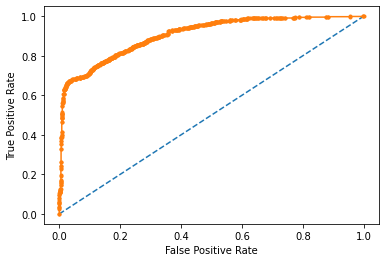

----------------------------------------------------


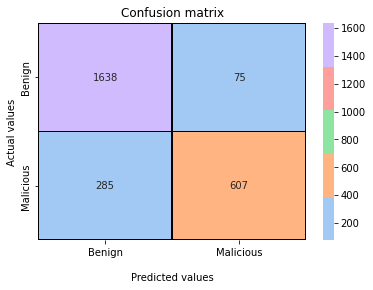


****************************************************


In [ ]:
logistic_regression = LogisticRegression(random_state=42, max_iter=1000)

param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.0001, 0.001, 0.01, 0.1],
    "solver": ["liblinear", "saga"]
}

lr_grid = GridSearchCV(logistic_regression, param_grid=param_grid, cv=10)

lr_grid.fit(X_train_std, y_train)

lr_grid_pred = lr_grid.best_estimator_.predict(X_test_std)
lr_grid_pred_proba = lr_grid.best_estimator_.predict_proba(X_test_std)

classification_report(y_test, lr_grid_pred, lr_grid_pred_proba)

In [ ]:
lr_grid.best_params_

{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}

### 5.4 Multi Layer Perceptron

In [ ]:
perceptron = MLPClassifier(random_state=42, max_iter=1000)

param_grid = {
    "hidden_layer_sizes": [x for x in range(5, 10)],
    "activation": ["tanh", "relu"],
    "solver": ["sgd", "adam"],
    "alpha":  [0.0001, 0.001, 0.01],
}

perceptron_grid = GridSearchCV(perceptron, param_grid=param_grid, cv=10)

perceptron_grid.fit(X_train_std, y_train)

perceptron_grid_pred = perceptron_grid.best_estimator_.predict(X_test_std)
perceptron_grid_pred_proba = perceptron_grid.best_estimator_.predict_proba(X_test_std)

classification_report(y_test, perceptron_grid_pred)

TypeError: ignored

In [ ]:
perceptron_grid_pred_proba = perceptron_grid.best_estimator_.predict_proba(X_test_std)


****************************************************
accuracy: 0.9102
roc_auc_score: 0.8890
----------------------------------------------------
f1_score            :0.8624
recall_score        :0.8217
precision_score     :0.9072
----------------------------------------------------
ROC-Curve



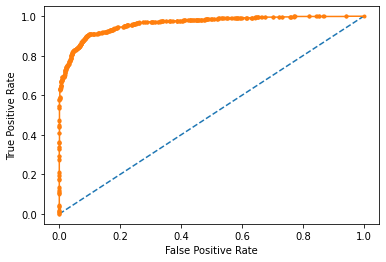

----------------------------------------------------
Confusion matrix



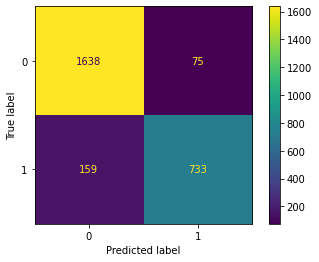


****************************************************


In [ ]:
classification_report(y_test, perceptron_grid_pred, perceptron_grid_pred_proba)

In [ ]:
perceptron_grid.best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': 9,
 'solver': 'adam'}

###5.5 XGBoost


****************************************************
accuracy: 0.9263
roc_auc_score: 0.9106
----------------------------------------------------
f1_score            :0.8889
recall_score        :0.8610
precision_score     :0.9187
----------------------------------------------------
ROC-Curve



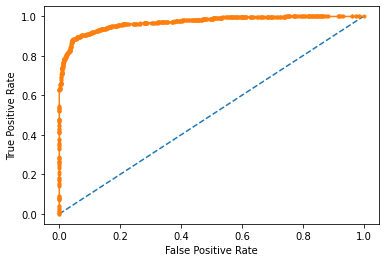

----------------------------------------------------


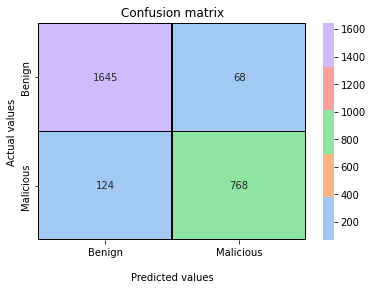


****************************************************


In [ ]:
xgboost = XGBClassifier(random_state=42)

param_grid = {
    "colsample_bytree": [0.7, 0.8],
    "max_depth": [3, 4],
    "min_child_weight": [4, 5],
    "subsample": [i/10.0 for i in range(6, 11)],
    "gamma": [i/10.0 for i in range(3, 6)],
}

xgb_grid = GridSearchCV(xgboost, param_grid=param_grid, cv=10)

xgb_grid.fit(X_train_std, y_train)
xgb_grid_pred = xgb_grid.best_estimator_.predict(X_test_std)
xgb_grid_pred_proba = xgb_grid.best_estimator_.predict_proba(X_test_std)

classification_report(y_test, xgb_grid_pred, xgb_grid_pred_proba)

In [ ]:
xgb_grid.best_params_   

{'colsample_bytree': 0.8,
 'gamma': 0.3,
 'max_depth': 4,
 'min_child_weight': 4,
 'subsample': 0.7}

##Step 6: Model evaluation

In [ ]:
X.head()

,is_ip,is_https_secured,url_length,subdomain_len,tld_len,fld_len,digit_count,letter_count,@,?,...,#,%,+,$,!,*,",",//,contains_shortening,special_count
514768,0,0,48,8,3,9,0,41,0,0,...,0,0,0,0,0,0,0,0,0,4
222536,0,0,44,10,2,6,0,38,0,0,...,0,0,0,0,0,0,0,0,0,3
276748,0,0,31,0,3,11,0,27,0,1,...,0,0,0,0,0,0,0,0,0,3
50193,0,0,30,0,3,9,0,25,0,0,...,0,0,0,0,0,0,0,0,0,1
339822,0,0,32,0,3,12,0,28,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
y

514768    0
222536    0
276748    0
50193     0
339822    0
         ..
130543    1
550575    1
550863    1
540674    1
552022    1
Name: target, Length: 13023, dtype: uint8

In [ ]:
!pip show xgboost

Name: xgboost
Version: 0.90
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: None
Author-email: None
License: Apache-2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, scipy
Required-by: 
